In [1]:
import sys
sys.path.append('/home/pranavsatheesh/host_galaxies/')

In [2]:
import illustris_python as il
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

In [3]:
SOLAR_MASS_G = 1.989e33
MSOL = 1.988409870698051e+33
h = 0.6774

In [4]:
basePath = '/orange/lblecha/IllustrisTNG/Runs/TNG50-1/output'
merger_file_path = '/home/pranavsatheesh/host_galaxies/data/merger_files'

merger_file_1bh = merger_file_path+'/galaxy-mergers_TNG50-1_gas-100_dm-100_star-100_bh-001.hdf5'#merger file
merger_file_nobh = merger_file_path+'/galaxy-mergers_TNG50-1_gas-100_dm-100_star-100_bh-000.hdf5'

In [5]:
# Load scale factors and redshifts
snap_list = np.arange(1,100)
redshifts = np.array([il.groupcat.loadHeader(basePath, snap)['Redshift'].item() for snap in snap_list])
scale_factors = np.array([il.groupcat.loadHeader(basePath, snap)['Time'].item() for snap in snap_list])

In [6]:
fmergers = h5py.File(merger_file_1bh, 'r')
fmergers.keys()

<KeysViewHDF5 ['InfallMassRatio', 'ProgMassRatio', 'ProgMassRatio_mod', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloCM', 'SubhaloGrNr', 'SubhaloHalfmassRadType', 'SubhaloLenType', 'SubhaloMassInHalfRadType', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloPos', 'SubhaloSFR', 'SubhaloVel', 'SubhaloVelDisp', 'fpMass', 'fpMass_mod', 'fpMasshistory', 'fpinfallMass', 'fpsnaphistory', 'npMass', 'npMass_mod', 'npMasshistory', 'npinfallMass', 'npsnaphistory', 'shids_subf', 'shids_tree', 'snaps', 'time']>

In [7]:
def get_scale_factors(basePath, filename="output_scale_factors.txt"):
    path = basePath.split('/output')[0]
    #print(path)
    f = open(path+"/"+filename,'r')
    snaptimes = np.array([float(line) for line in f.readlines()])
    f.close()
    print(f"snapshot scale factors in {path}:")
    print(snaptimes)
    return snaptimes

scale_factors_tng = get_scale_factors(basePath)
one_plus_z = 1.0 / scale_factors_tng

snapshot scale factors in /orange/lblecha/IllustrisTNG/Runs/TNG50-1:
[0.04751386 0.06254232 0.07704034 0.08350282 0.09093728 0.09625777
 0.09997661 0.10582597 0.11096103 0.11634526 0.12141409 0.12491542
 0.13348287 0.14263794 0.1460576  0.15314485 0.16057599 0.1667797
 0.17653754 0.18422877 0.19316822 0.1996827  0.21236949 0.22267443
 0.2334794  0.24949284 0.25668768 0.26787083 0.2795412  0.29034102
 0.30155808 0.31172794 0.32224077 0.33310814 0.344342   0.35427208
 0.36448853 0.37499959 0.38398999 0.39506344 0.40071935 0.41423335
 0.42416436 0.43433346 0.44474635 0.45325613 0.46412269 0.47300321
 0.48205365 0.49127726 0.50067736 0.51268081 0.52002058 0.52997065
 0.54011111 0.55044559 0.55832602 0.56900902 0.57715521 0.5881985
 0.59661941 0.60803512 0.61674002 0.62556955 0.63452548 0.64666649
 0.65592445 0.66531496 0.6748399  0.68450121 0.69430083 0.70424076
 0.71432298 0.72454955 0.73492252 0.74192021 0.75254187 0.76331559
 0.77058363 0.78532797 0.7928056  0.80415576 0.81566841 0.8234

### Checking if past max mass can be a reliable measure for all mergers

For multiple mergers (e.g triples), check this especially and flag cases where the first merger's past max mass is at a later snapshot that the second merger's past max mass. If not, then the first merger and second mergers are treated as two seperate mergers with their respective past masses recorded.

In [12]:
def display_past_max_mass_and_infall_mass(i):

    fig,ax = plt.subplots(1, 1, figsize=(8,6))
    ax.plot(one_plus_z[fmergers['fpsnaphistory'][i].astype(int)], fmergers['fpMasshistory'][i] * 10**10 / h)
    ax.plot(one_plus_z[fmergers['npsnaphistory'][i].astype(int)], fmergers['npMasshistory'][i] * 10**10 / h)

    npmaxpastmass_index = np.where(fmergers['npMasshistory'][i]*1e10/h==fmergers['npMass'][i])[0][0]
    npinfallmass_index = np.where(fmergers['npMasshistory'][i]*1e10/h==fmergers['npinfallMass'][i])[0][0]

    ax.axvline(one_plus_z[fmergers['npsnaphistory'][i][npmaxpastmass_index].astype(int)], color='red', linestyle='--', label='NP maxpastmass')
    ax.axvline(one_plus_z[fmergers['npsnaphistory'][i][npinfallmass_index].astype(int)], color='brown', linestyle='--', label='NP infallmass')

    ax.legend()
    ax.set_yscale('log',base=10)
    ax.set_xlabel('1+z')
    ax.set_ylabel('$M_{\star}$[$M_\odot$]')
    ax.set_ylim(1e6,)

    return fig,ax

In [13]:
def plot_mass_histoties_for_triples(descidx,fpidx):

    fig,ax = plt.subplots(1,1, figsize=(8,6))
    #first merger - descidx
    ax.plot(one_plus_z[fmergers['fpsnaphistory'][descidx].astype(int)], fmergers['fpMasshistory'][descidx] * 10**10 / h,linestyle='-.',color='red')
    ax.plot(one_plus_z[fmergers['npsnaphistory'][descidx].astype(int)], fmergers['npMasshistory'][descidx] * 10**10 / h,linestyle='-.',color='red')

    npmaxpastmass_index = np.where(fmergers['npMasshistory'][descidx]*1e10/h==fmergers['npMass'][descidx])[0][0]
    npinfallmass_index = np.where(fmergers['npMasshistory'][descidx]*1e10/h==fmergers['npinfallMass'][descidx])[0][0]

    ax.axvline(one_plus_z[fmergers['npsnaphistory'][descidx][npmaxpastmass_index].astype(int)], color='red', linestyle='--', label='first merger maxpastmass')

    ax.axvline(one_plus_z[fmergers['npsnaphistory'][descidx][npinfallmass_index].astype(int)], color='brown', linestyle='-.', label='first merger infallmass')

    #second merger - fpidx
    ax.plot(one_plus_z[fmergers['fpsnaphistory'][fpidx].astype(int)], fmergers['fpMasshistory'][fpidx] * 10**10 / h,linestyle='--',color='violet')

    ax.plot(one_plus_z[fmergers['npsnaphistory'][fpidx].astype(int)], fmergers['npMasshistory'][fpidx] * 10**10 / h,linestyle='--',color='violet')

    npmaxpastmass_index = np.where(fmergers['npMasshistory'][fpidx]*1e10/h==fmergers['npMass'][fpidx])[0][0]
    npinfallmass_index = np.where(fmergers['npMasshistory'][fpidx]*1e10/h==fmergers['npinfallMass'][fpidx])[0][0]

    ax.axvline(one_plus_z[fmergers['npsnaphistory'][fpidx][npmaxpastmass_index].astype(int)], color='orange', linestyle='--', label='second merger maxpastmass')

    ax.axvline(one_plus_z[fmergers['npsnaphistory'][fpidx][npinfallmass_index].astype(int)], color='black', linestyle='-.', label='second merger infallmass')

    print("first merger:",one_plus_z[fmergers['npsnaphistory'][descidx][npmaxpastmass_index].astype(int)])
    print("second merger:",one_plus_z[fmergers['npsnaphistory'][fpidx][npmaxpastmass_index].astype(int)])

    ax.legend()
    ax.set_yscale('log',base=10)
    ax.set_xlabel('1+z')
    ax.set_ylabel('$M_{\star}$[$M_\odot$]')
    ax.set_ylim(1e6,)

    return fig, ax

In [14]:
def find_snaps_of_double_mergers(descidx, fpidx):

    npmaxpastmass_index = np.where(fmergers['npMasshistory'][descidx]*1e10/h==fmergers['npMass'][descidx])[0][0]

    first_merger_snap = fmergers['npsnaphistory'][descidx][npmaxpastmass_index].astype(int)
     
    npmaxpastmass_index = np.where(fmergers['npMasshistory'][fpidx]*1e10/h==fmergers['npMass'][fpidx])[0][0]

    second_merger_snap = fmergers['npsnaphistory'][fpidx][npmaxpastmass_index].astype(int)

    # print("first merger:",one_plus_z[fmergers['npsnaphistory'][descidx][npmaxpastmass_index].astype(int)])
    # print("second merger:",one_plus_z[fmergers['npsnaphistory'][fpidx][npmaxpastmass_index].astype(int)])
    
    return first_merger_snap, second_merger_snap

(2.5, 15.0)

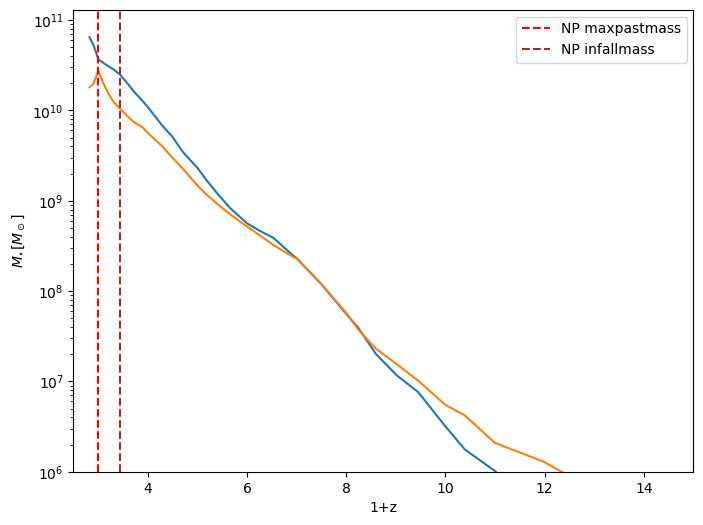

In [15]:
#An example of a galaxy merger with the infall mass and the past max mass of the next progenitor
fig,ax = display_past_max_mass_and_infall_mass(0)
ax.set_xlim(2.5,15)

Flagging the multiple merger with the common ID: 48871498
First_merger_index:59 and Second_merger_index:58
False 48871498 59 58
first merger snap: 31
second merger snap: 29
first merger: 3.5772902681578285
second merger: 3.444225702052799


(3.0, 5.0)

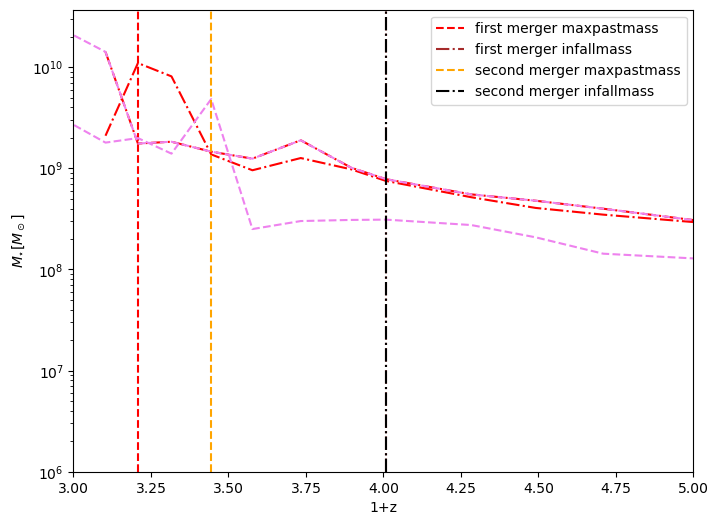

In [25]:
#finding multiple mergers by checking cases when the descendent ID of a merger is the same as the first progenitor ID of another merger

fpIDs = fmergers['shids_tree'][:,0]
npIDs = fmergers['shids_tree'][:,1]
descIDs = fmergers['shids_tree'][:,2]

commonids = np.intersect1d(descIDs, fpIDs)
first_merger_id = np.argwhere(descIDs==commonids[0])[0][0]
second_merger_id = np.argwhere(fpIDs==commonids[0])[0][0]


first_merger_pastmaxmass_snap,second_merger_pastmaxmass_snap = find_snaps_of_double_mergers(first_merger_id, second_merger_id)

flagged_shids_tree = []

for i in range(len(commonids)):
    first_merger_id = np.argwhere(descIDs==commonids[i])[0][0]
    second_merger_id = np.argwhere(fpIDs==commonids[i])[0][0]

    first_merger_pastmaxmass_snap,second_merger_pastmaxmass_snap = find_snaps_of_double_mergers(first_merger_id, second_merger_id)

    if first_merger_pastmaxmass_snap>second_merger_pastmaxmass_snap:
        flagged_shids_tree.append(commonids[i])
        print("Flagging the multiple merger with the common ID: %d"%(commonids[i]))
        print("First_merger_index:%d and Second_merger_index:%d"%(first_merger_id,second_merger_id))
        print("False",commonids[i],first_merger_id,second_merger_id)
        print("first merger snap:",first_merger_pastmaxmass_snap)
        print("second merger snap:",second_merger_pastmaxmass_snap)

fig,ax = plot_mass_histoties_for_triples(59,58)
ax.set_xlim(3,5)

In this case the second merger's max past mass occurs before the first merger's max past mass.

## Should we neglect this merger or use their masses at the time of merger instead ?

In [33]:
flaged_merger_1 = np.where(fpIDs==flagged_shids_tree)[0][0]
flagged_merger_2 = np.where(descIDs==flagged_shids_tree)[0][0]

In [34]:
fpIDs = fmergers['shids_tree'][:,0]
npIDs = fmergers['shids_tree'][:,1]
descIDs = fmergers['shids_tree'][:,2]

commonids = np.intersect1d(descIDs, npIDs)
print(commonids)

[140758427]


In [41]:
first_merger_id = np.argwhere(descIDs==commonids[0])[0][0]
second_merger_id = np.argwhere(npIDs==commonids[0])[0][0]


first_merger_pastmaxmass_snap,second_merger_pastmaxmass_snap = find_snaps_of_double_mergers(first_merger_id, second_merger_id)


for i in range(len(commonids)):
    first_merger_id = np.argwhere(descIDs==commonids[i])[0][0]
    second_merger_id = np.argwhere(npIDs==commonids[i])[0][0]

    first_merger_pastmaxmass_snap,second_merger_pastmaxmass_snap = find_snaps_of_double_mergers(first_merger_id, second_merger_id)

    if first_merger_pastmaxmass_snap>second_merger_pastmaxmass_snap:
        flagged_shids_tree.append(commonids[i])
        print("Flagging the multiple merger with the common ID: %d"%(commonids[i]))
        print("First_merger_index:%d and Second_merger_index:%d"%(first_merger_id,second_merger_id))
        print("False",commonids[i],first_merger_id,second_merger_id)
        print("first merger snap:",first_merger_pastmaxmass_snap)
        print("second merger snap:",second_merger_pastmaxmass_snap)
